In [ ]:
!pip install -U datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
!pip install -U underthesea

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 657.8/657.8 kB 25.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 17.5 MB/s eta 0:00:00


# Tải dữ liệu

In [ ]:
from datasets import load_dataset

dataset = load_dataset("uitnlp/vietnamese_students_feedback")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/4.79k [00:00<?, ?B/s]

vietnamese_students_feedback.py:   0%|          | 0.00/4.97k [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/475k [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/63.3k [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/134k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/11426 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1583 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3166 [00:00<?, ? examples/s]

In [ ]:
from underthesea import word_tokenize
from underthesea import text_normalize
from underthesea import pos_tag, sentiment
from imblearn.over_sampling import SMOTE

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MaxAbsScaler
from sklearn.model_selection import KFold, cross_val_score

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [ ]:
train_df = dataset['train'].to_pandas()
val_df = dataset['validation'].to_pandas()
test_df = dataset['test'].to_pandas()

# Hợp nhất tập train + validation làm dữ liệu train

In [ ]:
df = pd.concat([train_df, val_df], ignore_index=True)
df = df.sample(frac=1).reset_index(drop=True)
df

,sentence,sentiment,topic
0,giảng viên không đến lớp nhưng không báo trước...,0,0
1,cô truyền đạt kiến thức rất hiệu quả .,2,0
2,cách dạy sáng tạo .,2,0
3,thầy cho ít bài tập quá .,0,0
4,"giảng viên rất vui vẻ , phương pháp của thầy g...",2,0
...,...,...,...
13004,"giảng viên vui tính , hòa đồng .",2,0
13005,cần chia nhóm học tập .,0,3
13006,thầy day trực quan dễ hiểu .,2,0
13007,môn học cần thiết kế để sinh viên có cơ hội kh...,0,1


In [ ]:
import re
stop_words_vi = set(["là", "và", "một", "có", "những", "cho", "được", "tại", "với"])

def remove_stopwords_vi(text):
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words_vi]
    return ' '.join(filtered_words)

# Xử lý khoảng trắng trong câu
def clean_whitespace(text):
    return re.sub(r'\s+', ' ', text).strip()

# Đếm số lượng từ trong văn bản
def count_words(text):
    words = text.split(' ')
    return len(words)

# Đếm số lượng ký tự trong văn bản (bao gồm khoảng trắng)
def count_characters(text):
    return len(text)

# Đếm số lượng dấu câu trong văn bản
def count_punctuation(text):
    punctuation_pattern = r'[.,!?;:"\'()]'
    punctuation_matches = re.findall(punctuation_pattern, text)
    return len(punctuation_matches)

In [ ]:
def process_data(dataset):
  len_test = len(dataset)

  for i in range(len_test):
    dataset['sentence'][i] = clean_whitespace(dataset['sentence'][i])

  for i in range(len_test):
    dataset['sentence'][i] = remove_stopwords_vi(dataset['sentence'][i])

  for i in range(len_test):
    dataset['sentence'][i] = word_tokenize(dataset['sentence'][i], format="text")

  dataset['num_words'] = [len(item.split(' ')) for item in list(dataset['sentence'])]
  dataset['length'] = [len(item) for item in list(dataset['sentence'])]
  dataset['num_punc'] = [count_punctuation(item) for item in list(dataset['sentence'])]

  # Tạo các cột mới và khởi tạo giá trị bằng 0
  dataset['num_verb'] = 0
  dataset['num_adj'] = 0

  for i in range(len(dataset)):
      verbs = []
      adjectives = []

      # POS tagging cho từng câu
      pos_tags = pos_tag(dataset['sentence'][i])

      # Lọc động từ và tính từ
      verbs = [word for word, pos in pos_tags if pos == 'V']
      adjectives = [word for word, pos in pos_tags if pos == 'A']

      # Gán số lượng động từ và tính từ
      dataset.at[i, 'num_verb'] = len(verbs)
      dataset.at[i, 'num_adj'] = len(adjectives)

In [ ]:
process_data(df)
df

Streaming output truncated to the last 5000 lines.
See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  dataset['sentence'][i] = word_tokenize(dataset['sentence'][i], format="text")
<ipython-input-8-7d539a320df9>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['sentence'][i] = word_tokenize(dataset['sentence'][i], format="text")
<ipython-input-8-7d539a320df9>:11: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object 

,sentence,sentiment,topic,num_words,length,num_punc,num_verb,num_adj
0,giảng_viên không đến lớp nhưng không báo trước...,0,0,21,128,3,4,0
1,cô truyền_đạt kiến_thức rất hiệu_quả .,2,0,6,38,1,1,1
2,cách dạy sáng_tạo .,2,0,4,19,1,1,0
3,thầy ít bài_tập quá .,0,0,5,21,1,1,1
4,"giảng_viên rất vui_vẻ , phương_pháp của thầy g...",2,0,12,78,2,2,1
...,...,...,...,...,...,...,...,...
13004,"giảng_viên vui_tính , hòa đồng .",2,0,6,32,2,0,0
13005,cần chia nhóm học_tập .,0,3,5,23,1,2,0
13006,thầy day trực_quan dễ hiểu .,2,0,6,28,1,2,1
13007,môn_học cần_thiết_kế để sinh_viên cơ_hội khảo_...,0,1,8,59,1,2,0


In [ ]:
df.describe()

,sentiment,topic,num_words,length,num_punc,num_verb,num_adj
count,13009.000000,13009.000000,13009.000000,13009.000000,13009.000000,13009.00000,13009.000000
mean,1.032132,0.428396,10.266431,55.603044,1.626797,2.56384,0.965947
std,0.978889,0.796940,7.322398,40.069823,0.943153,2.28368,1.009637
min,0.000000,0.000000,1.000000,1.000000,1.000000,0.00000,0.000000
25%,0.000000,0.000000,6.000000,30.000000,1.000000,1.00000,0.000000
50%,1.000000,0.000000,8.000000,44.000000,1.000000,2.00000,1.000000
75%,2.000000,1.000000,12.000000,69.000000,2.000000,3.00000,1.000000
max,2.000000,3.000000,125.000000,673.000000,12.000000,38.00000,9.000000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13009 entries, 0 to 13008
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentence   13009 non-null  object
 1   sentiment  13009 non-null  int64 
 2   topic      13009 non-null  int64 
 3   num_words  13009 non-null  int64 
 4   length     13009 non-null  int64 
 5   num_punc   13009 non-null  int64 
 6   num_verb   13009 non-null  int64 
 7   num_adj    13009 non-null  int64 
dtypes: int64(7), object(1)
memory usage: 813.2+ KB


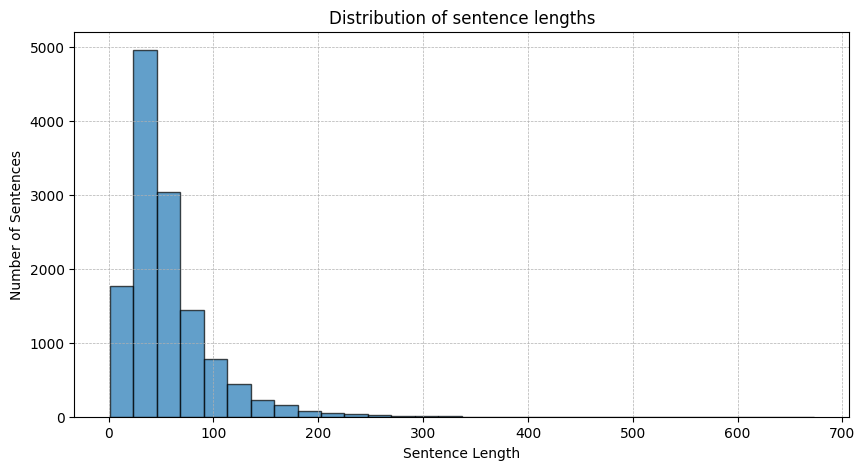

In [ ]:
# Plot histogram
plt.figure(figsize=(10, 5))
plt.hist(df["length"], bins=30, edgecolor='k', alpha=0.7)
plt.title('Distribution of sentence lengths')
plt.xlabel('Sentence Length')
plt.ylabel('Number of Sentences')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

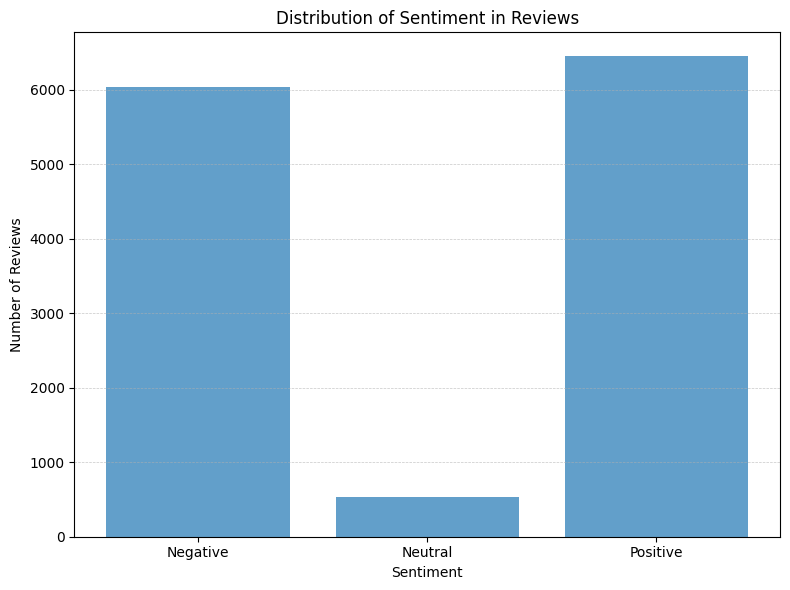

In [ ]:
# Count the occurrences of each label (semantic/sentiment)
label_counts = df['sentiment'].value_counts().sort_index()

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Bar chart for semantic/sentiment
labels = ['Negative', 'Neutral', 'Positive']  # updated labels
ax.bar(labels, label_counts, alpha=0.7)

# Customize the plot
ax.set_title('Distribution of Sentiment in Reviews')
ax.set_xlabel('Sentiment')
ax.set_ylabel('Number of Reviews')
ax.grid(True, axis='y', linestyle='--', linewidth=0.5, alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
attributes = ['sentence', 'num_words', 'length', 'num_punc', 'num_verb', 'num_adj']
X = df['sentence']
y = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Xử lý mất cân bằng dữ liệu

In [ ]:
from sklearn.utils import resample

# Separate neutral comments
neutral_indices = np.where(y_train == 1)[0]
oversample_size = len(y_train[y_train == 0]) - len(neutral_indices)

# Over-sample the neutral comments
oversampled_neutral_indices = resample(neutral_indices,
                                       replace=True,
                                       n_samples=oversample_size)

# Combine the original sentences and labels with the oversampled data
oversampled_neutral_sentences = np.array(X_train)[oversampled_neutral_indices]

train_sentences_oversampled = np.concatenate([X_train, oversampled_neutral_sentences], axis=0)
train_labels_oversampled = np.concatenate([y_train, np.array([1] * oversample_size)], axis=0)

In [ ]:
oversampled_neutral_sentences = np.array(X_train)[oversampled_neutral_indices]

train_sentences_oversampled = np.concatenate([X_train, oversampled_neutral_sentences], axis=0)
train_labels_oversampled = pd.Series(train_labels_oversampled)

In [ ]:
# Count occurrences of each label in train_labels_oversampled
unique_labels, counts = np.unique(train_labels_oversampled, return_counts=True)

# Display the distribution
for label, count in zip(unique_labels, counts):
    print(f"Label {label}: {count}")

Label 0: 4806
Label 1: 4806
Label 2: 5173


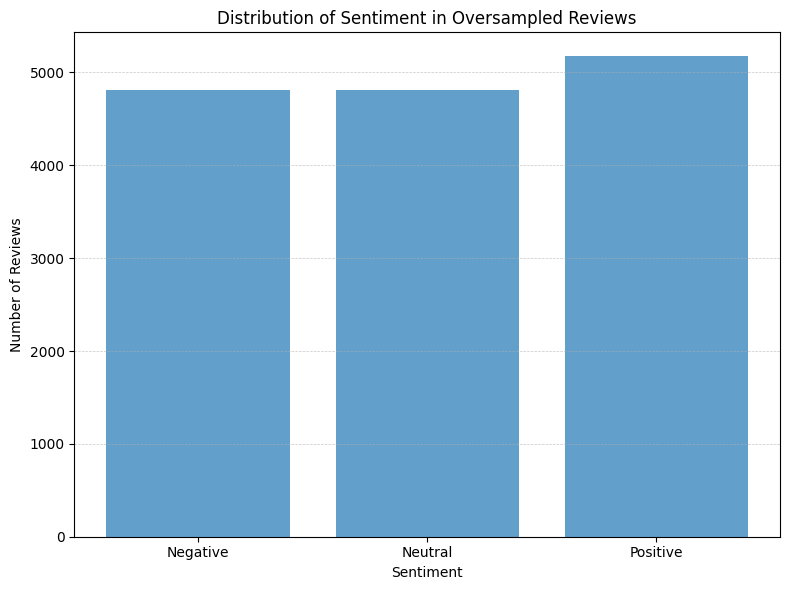

In [ ]:
# Count the occurrences of each label (semantic/sentiment) after oversampling
label_counts_oversampled = pd.Series(train_labels_oversampled).value_counts().sort_index()

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Bar chart for semantic/sentiment after oversampling
labels = ['Negative', 'Neutral', 'Positive']  # updated labels
ax.bar(labels, label_counts_oversampled, alpha=0.7)

# Customize the plot
ax.set_title('Distribution of Sentiment in Oversampled Reviews')
ax.set_xlabel('Sentiment')
ax.set_ylabel('Number of Reviews')
ax.grid(True, axis='y', linestyle='--', linewidth=0.5, alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()


# **TfidfVectorizer**

#### Demo Tfidf Vectorizer

In [ ]:
# Initialize the TfidfVectorizer
vectorizer = TfidfVectorizer()

# Fit the vectorizer on the training data only
vectorizer.fit(X_train)

TfidfVectorizer()

In [ ]:
sample_sentences = df['sentence'].head(5).tolist() # select a sample of sentences
sample_transformed = vectorizer.fit_transform(sample_sentences) # transform the sample sentences

sample_array = sample_transformed.toarray() # convert the transformed data

# Print results for each sentence in the sample
for idx, sentence in enumerate(sample_sentences):
    print(f"Sentence: {sentence}")
    print("Token:")
    for token, count in zip(vectorizer.get_feature_names_out(), sample_array[idx]):
        if count > 0:
            print(f"{token} : {count}")
    print("------\n")

Sentence: giảng_viên không đến lớp nhưng không báo trước phòng đào_tạo hay lớp trưởng ( không thông_báo nghỉ trên daadotuitdotedudotvn ) .
Token:
báo : 0.19744610009501865
daadotuitdotedudotvn : 0.19744610009501865
giảng_viên : 0.15929827033491994
hay : 0.19744610009501865
không : 0.592338300285056
lớp : 0.3948922001900373
nghỉ : 0.19744610009501865
nhưng : 0.19744610009501865
phòng : 0.19744610009501865
thông_báo : 0.19744610009501865
trên : 0.19744610009501865
trước : 0.19744610009501865
trưởng : 0.19744610009501865
đào_tạo : 0.19744610009501865
đến : 0.19744610009501865
------

Sentence: cô truyền_đạt kiến_thức rất hiệu_quả .
Token:
cô : 0.4636932227319092
hiệu_quả : 0.4636932227319092
kiến_thức : 0.4636932227319092
rất : 0.3741047724501573
truyền_đạt : 0.4636932227319092
------

Sentence: cách dạy sáng_tạo .
Token:
cách : 0.5773502691896257
dạy : 0.5773502691896257
sáng_tạo : 0.5773502691896257
------

Sentence: thầy ít bài_tập quá .
Token:
bài_tập : 0.5233582502695435
quá : 0.5233

#### Text --> vector with Tfidf vectorizer

In [ ]:
# Initialize the TfidfVectorizer
vectorizer = TfidfVectorizer()

X_oversampled_bow = vectorizer.fit_transform(train_sentences_oversampled)
y_oversampled_bow = train_labels_oversampled

# Build model

## Một số hàm thông dụng
- def calculate_results(y_true, y_pred):
- def kfold_evaluation(model, X, y, kfold):
- def format_metrics_compact(metrics):
- def display_all_folds_results(model_name, model_results):
- def display_each_fold_result(model_name, fold_results):

In [ ]:
def calculate_results(y_true, y_pred):
    '''
    Calculate accuracy, precision, recall, f1 score for a model
    '''
    model_accuracy = accuracy_score(y_true, y_pred) * 100  # Scale to 1-100
    model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")

    model_results = {
        "accuracy": model_accuracy,
        "precision": model_precision,
        "recall": model_recall,
        "f1": model_f1
    }

    return model_results

In [ ]:
import numpy as np
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from collections import Counter
from copy import deepcopy
import time

def kfold_evaluation(model, X, y, k=5, param_grid=None):
    """
    Thực hiện đánh giá KFold trên mô hình học máy.

    Tham số:
    - model: Mô hình học máy.
    - X, y: Dữ liệu đặc trưng và nhãn.
    - k: Số fold trong Stratified KFold.
    - param_grid: Tham số cho GridSearchCV.

    Trả về:
    - best_model: Mô hình được huấn luyện trên toàn bộ dữ liệu.
    - fold_results: Kết quả đánh giá trên từng fold.
    - avg_metrics: Kết quả trung bình trên tất cả các fold.
    """

    fold_results = []
    fold_result_each_kfold = []
    best_model = None
    best_metric = -np.inf

    # Sử dụng StratifiedKFold
    kfold = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

    start_time = time.time()
    for fold, (train_index, val_index) in enumerate(kfold.split(X, y), start=1):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]
        fold_best_model = None

        print(f"\nFold {fold}")
        print("  Train label distribution:", dict(Counter(y_train)))
        print("  Validation label distribution:", dict(Counter(y_val)))

        if param_grid:
            print("  Optimizing hyperparameters using GridSearchCV...")
            grid_search = GridSearchCV(model, param_grid, cv=k, scoring='accuracy', n_jobs=-1)
            grid_search.fit(X_train, y_train)
            fold_best_model = grid_search.best_estimator_

            print(f"  Best parameters: {grid_search.best_params_}")
        else:
            fold_best_model = deepcopy(model)
            fold_best_model.fit(X_train, y_train)

        # Dự đoán và tính toán các chỉ số
        train_predictions = fold_best_model.predict(X_train)
        val_predictions = fold_best_model.predict(X_val)

        # Calculate metrics for both sets
        train_metrics = calculate_results(y_train, train_predictions)
        val_metrics = calculate_results(y_val, val_predictions)

        print(f"  Metrics on fold {fold}: {val_metrics}")

        fold_result = {
            'fold': fold,
            'train_metrics': train_metrics,
            'validation_metrics': val_metrics
        }

        current_metric = val_metrics["f1"]
        if current_metric > best_metric:
            best_metric = current_metric
            best_model = deepcopy(fold_best_model)
            print(f"  New best model found on Fold {fold} with f1: {best_metric}")

        fold_results.append(val_metrics)
        fold_result_each_kfold.append(fold_result)

    # Tính toán trung bình các chỉ số
    avg_metrics = {
        "accuracy": np.mean([result["accuracy"] for result in fold_results]),
        "precision": np.mean([result["precision"] for result in fold_results]),
        "recall": np.mean([result["recall"] for result in fold_results]),
        "f1": np.mean([result["f1"] for result in fold_results]),
    }

    print("\nAverage Metrics Across Folds:", avg_metrics)
    print("Total Time Taken: {:.2f} seconds".format(time.time() - start_time))
    print("\n Classification Report Validation: \n", classification_report(y_val, val_predictions))

    return best_model, fold_result_each_kfold, avg_metrics

In [ ]:
def format_metrics_compact(metrics):
    return ", ".join([f"{key.capitalize()}: {value:.2f}" for key, value in metrics.items()])

def display_all_folds_results(model_name, model_results):
    print(f"Average {model_name} Performance Metrics Across All Folds (on validation data):")
    print(f"- Accuracy: {model_results['accuracy']:.2f}%")
    print(f"- Precision: {model_results['precision']:.4f}")
    print(f"- Recall: {model_results['recall']:.4f}")
    print(f"- F1 Score: {model_results['f1']:.4f}")

In [ ]:
def display_each_fold_result(model_name, fold_results):
    '''
    Print metrics of training and validation data on each KFold and plot the accuracy graph using Seaborn.
    '''
    # Set up the seaborn style and palette
    sns.set(style="whitegrid", palette="muted")
    colors = ["#3498db", "#e74c3c"]  # Blue for Training, Red for Validation

    # Header
    print(f"{model_name} Performance Metrics Across Each Fold (on training and validation data):")
    print()
    print(f"{'Fold':<5} | {'Training Metrics':<70} | {'Validation Metrics':<70}")
    print("-" * 150)

    # Prepare data for plotting
    train_accuracies = []
    val_accuracies = []
    folds = []
    # Display results for each fold and collect data for graph
    for result in fold_results:
        train_metrics_formatted = format_metrics_compact(result['train_metrics'])
        val_metrics_formatted = format_metrics_compact(result['validation_metrics'])
        print(f"{result['fold']:<5} | {train_metrics_formatted:<70} | {val_metrics_formatted:<70}")

        # Append data for graph
        folds.append(result['fold'])
        train_accuracies.append(result['train_metrics']['accuracy'])
        val_accuracies.append(result['validation_metrics']['accuracy'])

    # Plotting the accuracies using Seaborn
    fig, ax = plt.subplots(figsize=(10, 4))
    sns.lineplot(x=folds, y=train_accuracies, label='Training Accuracy', marker='o', color=colors[0])
    sns.lineplot(x=folds, y=val_accuracies, label='Validation Accuracy', marker='o', color=colors[1])
    ax.set_facecolor('#f8f9fa')  # Light gray background

    # Adding percentages on markers
    label_offset = 0.25  # Increased vertical offset for the labels
    for i, (tr_acc, val_acc) in enumerate(zip(train_accuracies, val_accuracies)):
        ax.text(folds[i], tr_acc + label_offset, f"{tr_acc:.2f}%", ha='center', va='bottom')
        ax.text(folds[i], val_acc + label_offset, f"{val_acc:.2f}%", ha='center', va='bottom')

    plt.title(f"{model_name} model: Training vs Validation Accuracy per Fold")
    plt.xlabel('Fold')
    plt.ylabel('Accuracy (%)')
    plt.xticks(folds)
    plt.legend()
    ax.margins(y=0.2)  # Add 10% padding to the top and bottom
    fig.tight_layout()
    plt.show()

## **Machine Learning Model**


## Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsOneClassifier

lg_model = OneVsOneClassifier(LogisticRegression(class_weight='balanced', random_state=42))
param_grid = {
    'estimator__C': [0.01, 0.1, 1, 10],
    'estimator__solver': ['liblinear', 'lbfgs'],
}
lg_model, lg_each_fold_results, lg_results = kfold_evaluation(lg_model, X_oversampled_bow, y_oversampled_bow, param_grid = param_grid)


Fold 1
  Train label distribution: {2: 4138, 0: 3845, 1: 3845}
  Validation label distribution: {0: 961, 2: 1035, 1: 961}
  Optimizing hyperparameters using GridSearchCV...
  Best parameters: {'estimator__C': 10, 'estimator__solver': 'liblinear'}
  Metrics on fold 1: {'accuracy': 90.76766993574569, 'precision': 0.9107121083560936, 'recall': 0.9076766993574569, 'f1': 0.9072713439878902}
  New best model found on Fold 1 with f1: 0.9072713439878902

Fold 2
  Train label distribution: {0: 3845, 2: 4138, 1: 3845}
  Validation label distribution: {2: 1035, 0: 961, 1: 961}
  Optimizing hyperparameters using GridSearchCV...
  Best parameters: {'estimator__C': 10, 'estimator__solver': 'liblinear'}
  Metrics on fold 2: {'accuracy': 89.24585728779168, 'precision': 0.8996718560709019, 'recall': 0.8924585728779169, 'f1': 0.8927887368138624}

Fold 3
  Train label distribution: {2: 4138, 0: 3845, 1: 3845}
  Validation label distribution: {0: 961, 2: 1035, 1: 961}
  Optimizing hyperparameters using G

In [ ]:
display_all_folds_results("Naive Bayes MultinomialNB", lg_results)

Average Naive Bayes MultinomialNB Performance Metrics Across All Folds (on validation data):
- Accuracy: 90.31%
- Precision: 0.9072
- Recall: 0.9031
- F1 Score: 0.9029


Logistic Regression Performance Metrics Across Each Fold (on training and validation data):

Fold  | Training Metrics                                                       | Validation Metrics                                                    
------------------------------------------------------------------------------------------------------------------------------------------------------
1     | Accuracy: 95.66, Precision: 0.96, Recall: 0.96, F1: 0.96               | Accuracy: 90.77, Precision: 0.91, Recall: 0.91, F1: 0.91              
2     | Accuracy: 95.67, Precision: 0.96, Recall: 0.96, F1: 0.96               | Accuracy: 89.25, Precision: 0.90, Recall: 0.89, F1: 0.89              
3     | Accuracy: 95.43, Precision: 0.95, Recall: 0.95, F1: 0.95               | Accuracy: 90.56, Precision: 0.91, Recall: 0.91, F1: 0.91              
4     | Accuracy: 95.81, Precision: 0.96, Recall: 0.96, F1: 0.96               | Accuracy: 90.26, Precision: 0.91, Recall: 0.90, F1: 0.90           

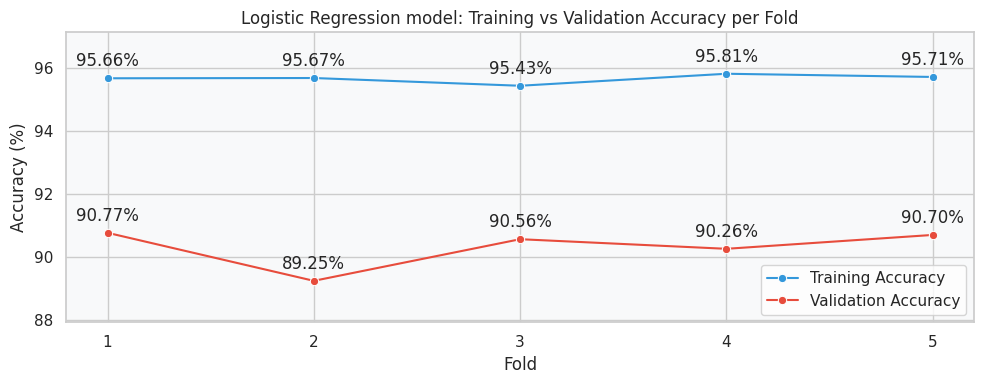

In [ ]:
display_each_fold_result("Logistic Regression", lg_each_fold_results)

## Random Forest

In [ ]:
rf_model = RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1)

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 5, 10]
}

rf_model, rf_each_fold_results, rf_results = kfold_evaluation(rf_model, X_oversampled_bow, y_oversampled_bow, k=5, param_grid = param_grid)
# lg_model, lg_each_fold_results, lg_results = kfold_evaluation(lg_model, X_oversampled_bow, y_oversampled_bow, param_grid = param_grid)


Fold 1
  Train label distribution: {2: 4138, 0: 3845, 1: 3845}
  Validation label distribution: {0: 961, 2: 1035, 1: 961}
  Optimizing hyperparameters using GridSearchCV...


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


  Best parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
  Metrics on fold 1: {'accuracy': 88.12986134595874, 'precision': 0.8858725953059337, 'recall': 0.8812986134595874, 'f1': 0.8804049692736876}
  New best model found on Fold 1 with f1: 0.8804049692736876

Fold 2
  Train label distribution: {0: 3845, 2: 4138, 1: 3845}
  Validation label distribution: {2: 1035, 0: 961, 1: 961}
  Optimizing hyperparameters using GridSearchCV...
  Best parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}
  Metrics on fold 2: {'accuracy': 86.47277646263105, 'precision': 0.875376810874895, 'recall': 0.8647277646263104, 'f1': 0.8641056880858613}

Fold 3
  Train label distribution: {2: 4138, 0: 3845, 1: 3845}
  Validation label distribution: {0: 961, 2: 1035, 1: 961}
  Optimizing hyperparameters using GridSearchCV...
  Best parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators'

In [ ]:
display_all_folds_results("Random Forest", rf_results)

Average Random Forest Performance Metrics Across All Folds (on validation data):
- Accuracy: 87.39%
- Precision: 0.8816
- Recall: 0.8739
- F1 Score: 0.8730


Random Forest Performance Metrics Across Each Fold (on training and validation data):

Fold  | Training Metrics                                                       | Validation Metrics                                                    
------------------------------------------------------------------------------------------------------------------------------------------------------
1     | Accuracy: 90.27, Precision: 0.91, Recall: 0.90, F1: 0.90               | Accuracy: 88.13, Precision: 0.89, Recall: 0.88, F1: 0.88              
2     | Accuracy: 90.59, Precision: 0.91, Recall: 0.91, F1: 0.91               | Accuracy: 86.47, Precision: 0.88, Recall: 0.86, F1: 0.86              
3     | Accuracy: 90.24, Precision: 0.91, Recall: 0.90, F1: 0.90               | Accuracy: 87.96, Precision: 0.89, Recall: 0.88, F1: 0.88              
4     | Accuracy: 90.62, Precision: 0.91, Recall: 0.91, F1: 0.91               | Accuracy: 86.64, Precision: 0.87, Recall: 0.87, F1: 0.87              
5 

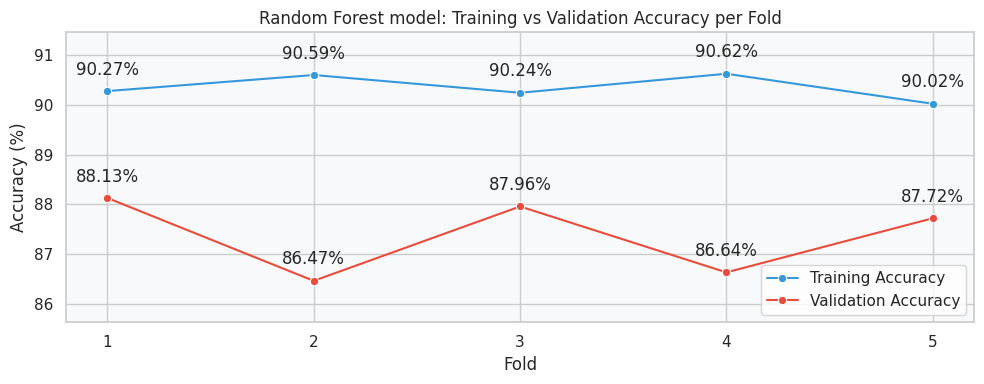

In [ ]:
display_each_fold_result("Random Forest", rf_each_fold_results)

## Model Naive Bayes MultinomialNB

In [ ]:
mnb_model = MultinomialNB()

mnb_model, mnb_each_fold_results, mnb_results = kfold_evaluation(mnb_model, X_oversampled_bow, y_oversampled_bow)


Fold 1
  Train label distribution: {2: 4138, 0: 3845, 1: 3845}
  Validation label distribution: {0: 961, 2: 1035, 1: 961}
  Metrics on fold 1: {'accuracy': 83.0909705782888, 'precision': 0.8315181037528238, 'recall': 0.830909705782888, 'f1': 0.8303286172500944}
  New best model found on Fold 1 with f1: 0.8303286172500944

Fold 2
  Train label distribution: {0: 3845, 2: 4138, 1: 3845}
  Validation label distribution: {2: 1035, 0: 961, 1: 961}
  Metrics on fold 2: {'accuracy': 82.92188028407169, 'precision': 0.8291774552571133, 'recall': 0.8292188028407169, 'f1': 0.8289862528289385}

Fold 3
  Train label distribution: {2: 4138, 0: 3845, 1: 3845}
  Validation label distribution: {0: 961, 2: 1035, 1: 961}
  Metrics on fold 3: {'accuracy': 83.36151504903619, 'precision': 0.8348044777496919, 'recall': 0.8336151504903618, 'f1': 0.8332958765172088}
  New best model found on Fold 3 with f1: 0.8332958765172088

Fold 4
  Train label distribution: {2: 4139, 0: 3844, 1: 3845}
  Validation label di

In [ ]:
display_all_folds_results("Naive Bayes MultinomialNB", mnb_results)

Average Naive Bayes MultinomialNB Performance Metrics Across All Folds (on validation data):
- Accuracy: 83.14%
- Precision: 0.8319
- Recall: 0.8314
- F1 Score: 0.8311


Naive Bayes MultinomialNB Performance Metrics Across Each Fold (on training and validation data):

Fold  | Training Metrics                                                       | Validation Metrics                                                    
------------------------------------------------------------------------------------------------------------------------------------------------------
1     | Accuracy: 85.37, Precision: 0.85, Recall: 0.85, F1: 0.85               | Accuracy: 83.09, Precision: 0.83, Recall: 0.83, F1: 0.83              
2     | Accuracy: 85.75, Precision: 0.86, Recall: 0.86, F1: 0.86               | Accuracy: 82.92, Precision: 0.83, Recall: 0.83, F1: 0.83              
3     | Accuracy: 85.59, Precision: 0.86, Recall: 0.86, F1: 0.86               | Accuracy: 83.36, Precision: 0.83, Recall: 0.83, F1: 0.83              
4     | Accuracy: 85.82, Precision: 0.86, Recall: 0.86, F1: 0.86               | Accuracy: 82.21, Precision: 0.82, Recall: 0.82, F1: 0.82     

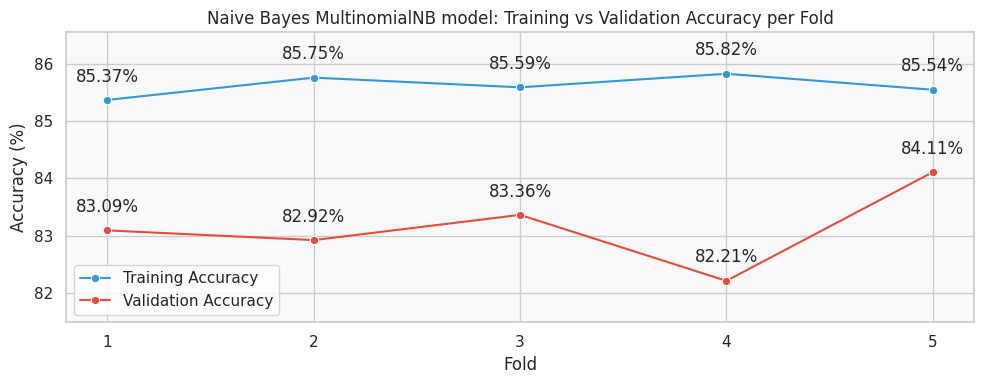

In [ ]:
display_each_fold_result("Naive Bayes MultinomialNB", mnb_each_fold_results)

## Model SVM

In [ ]:
svm_model = SVC()
param_grid = {'C': [0.1, 1, 10],
          'gamma': ['scale', 'auto'],
          'kernel': ['rbf', 'linear']}
svn_model, svm_each_fold_results, svm_results = kfold_evaluation(svm_model, X_oversampled_bow, y_oversampled_bow, param_grid=param_grid)


Fold 1
  Train label distribution: {2: 4138, 0: 3845, 1: 3845}
  Validation label distribution: {0: 961, 2: 1035, 1: 961}
  Optimizing hyperparameters using GridSearchCV...
  Best parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
  Metrics on fold 1: {'accuracy': 96.04328711531957, 'precision': 0.9603609389116541, 'recall': 0.9604328711531958, 'f1': 0.9603211320207219}
  New best model found on Fold 1 with f1: 0.9603211320207219

Fold 2
  Train label distribution: {0: 3845, 2: 4138, 1: 3845}
  Validation label distribution: {2: 1035, 0: 961, 1: 961}
  Optimizing hyperparameters using GridSearchCV...
  Best parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
  Metrics on fold 2: {'accuracy': 95.29928982076429, 'precision': 0.9530378101777073, 'recall': 0.9529928982076429, 'f1': 0.9527440286532906}

Fold 3
  Train label distribution: {2: 4138, 0: 3845, 1: 3845}
  Validation label distribution: {0: 961, 2: 1035, 1: 961}
  Optimizing hyperparameters using GridSearchCV...
  Bes

In [ ]:
display_all_folds_results("SVM", svm_results)

Average SVM Performance Metrics Across All Folds (on validation data):
- Accuracy: 95.61%
- Precision: 0.9562
- Recall: 0.9561
- F1 Score: 0.9559


SVM Performance Metrics Across Each Fold (on training and validation data):

Fold  | Training Metrics                                                       | Validation Metrics                                                    
------------------------------------------------------------------------------------------------------------------------------------------------------
1     | Accuracy: 99.98, Precision: 1.00, Recall: 1.00, F1: 1.00               | Accuracy: 96.04, Precision: 0.96, Recall: 0.96, F1: 0.96              
2     | Accuracy: 99.97, Precision: 1.00, Recall: 1.00, F1: 1.00               | Accuracy: 95.30, Precision: 0.95, Recall: 0.95, F1: 0.95              
3     | Accuracy: 99.98, Precision: 1.00, Recall: 1.00, F1: 1.00               | Accuracy: 95.94, Precision: 0.96, Recall: 0.96, F1: 0.96              
4     | Accuracy: 99.99, Precision: 1.00, Recall: 1.00, F1: 1.00               | Accuracy: 94.72, Precision: 0.95, Recall: 0.95, F1: 0.95              
5     | Accu

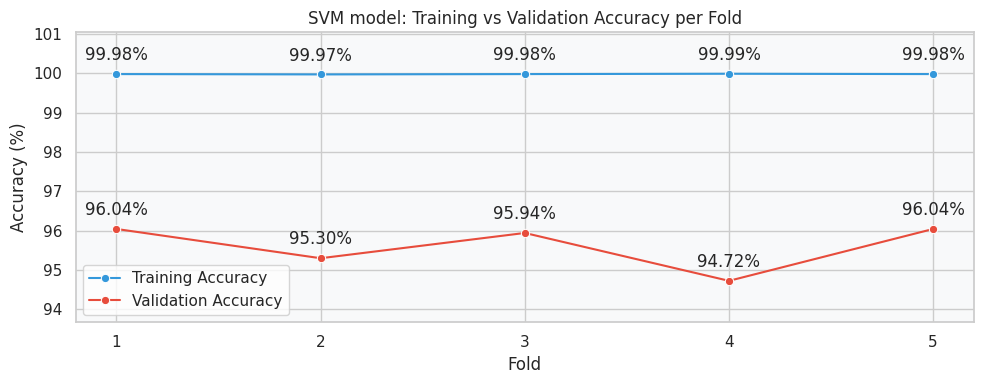

In [ ]:
display_each_fold_result("SVM", svm_each_fold_results)

# Model Evaluation

In [ ]:
MODELS = {
    'Logistic Regression': lg_model,
    'Naive Bayes MultinomialNB': mnb_model,
    'SVM': svn_model,
    'Random Forest': rf_model
}

reverse_label_map = {
    0: "negative",
    1: "neutral",
    2: "positive"
}

if isinstance(X_test, pd.Series):
    test_sentences = X_test.tolist()

In [ ]:
def predict_on_multiple_sentences(model_name, sentences=test_sentences, actual_labels=y_test.tolist(), vectorizer=vectorizer, label_map=reverse_label_map, MODELS=MODELS, n=10):
    # Select n random sentences and corresponding labels
    n = min(n, len(sentences)) # ensure that n does not exceed the number of available sentences
    random_indices = random.sample(range(len(sentences)), n)
    random_sentences = [sentences[i] for i in random_indices]
    random_actual_labels = [actual_labels[i] for i in random_indices]

    model = MODELS[model_name]
    # Print random n sentences
    for i, sentence in enumerate(random_sentences):
        test_features = vectorizer.transform([sentence])
        pred_labels = model.predict(test_features)

        # 0, 1, 2 --> negative, neutral, positive
        mapped_pred_label = label_map[pred_labels[0]]
        mapped_actual_label = label_map[random_actual_labels[i]]

        print(f"\nText: {sentence}\n")
        print(f"Prediction: {mapped_pred_label}", f", Actual: {mapped_actual_label}\n")

In [ ]:
predict_on_multiple_sentences(model_name='Naive Bayes MultinomialNB', n=10)


Text: nên bổ_sung phần xây_dựng kiến_trúc game , tiếp_xúc vơi các kiến_trúc game phổ_biến hiện_nay .

Prediction: negative , Actual: negative


Text: thoải_mái , hiệu_quả .

Prediction: positive , Actual: positive


Text: giảng_viên dạy rất nhiệt_tình , giúp_đỡ sinh_viên rất nhiều .

Prediction: positive , Actual: positive


Text: dạy chú_trọng đến người học .

Prediction: negative , Actual: positive


Text: cô dạy rất hay rất thực_tế bài_học .

Prediction: positive , Actual: positive


Text: khả_năng sư_phạm của cô theo em cần cải_thiện hơn .

Prediction: negative , Actual: negative


Text: phương_pháp dễ hiểu .

Prediction: positive , Actual: positive


Text: bài giảng_tạo cảm_giác hứng_thú tiếp_thu bài tốt .

Prediction: positive , Actual: positive


Text: cô dạy hay , truyền_đạt cũng tốt .

Prediction: positive , Actual: positive


Text: truyền_đạt nhiều kiến_thức .

Prediction: positive , Actual: positive



In [ ]:
predict_on_multiple_sentences(model_name='Logistic Regression', n=10)


Text: thầy cô nên đưa thêm các đoạn video ngắn để luyện học_sinh cách nghe tốt hơn .

Prediction: negative , Actual: negative


Text: thầy dạy như đúng rồi .

Prediction: positive , Actual: negative


Text: thích thầy chia_sẻ kinh_nghiệm .

Prediction: positive , Actual: positive


Text: thầy dạy hơi gây buồn_ngủ .

Prediction: negative , Actual: negative


Text: thực_sự thầy dạy rất tốt nên em không cần gì thêm .

Prediction: negative , Actual: positive


Text: khi ra đề_thi thầy nên kiểm_tra kỹ nội_dung đề , tránh để sót lỗi điển_hình như doubledot tên cột của bảng_trùng từ khóa của oracle .

Prediction: negative , Actual: negative


Text: chưa tận_dụng thời_gian hiệu_quả .

Prediction: negative , Actual: negative


Text: cần các công_cụ , kiến_thức sát công_nghệ mà các doanh_nghiệp thực_tế bên ngoài sử_dụng .

Prediction: negative , Actual: negative


Text: thời_gian thực_hành quá ít , phân_bổ không phù_hợp .

Prediction: negative , Actual: negative


Text: thầy nghỉ thường_xuyên ,

In [ ]:
predict_on_multiple_sentences(model_name='SVM', n=10)


Text: khả_năng truyền_đạt tốt .

Prediction: positive , Actual: positive


Text: giảng_dạy kết_hợp các hoạt_động giải_trí hiệu_quả .

Prediction: positive , Actual: positive


Text: em nghĩ đây sự_cố do phòng đào_tạo buộc thầy thay_đổi hình_thức thi , ban_đầu chúng_em thông_báo thi cuối kỳ trên máy_tính , nhưng sau đó lại phải thi trên giấy .

Prediction: negative , Actual: negative


Text: dạy hay , tâm_quyết nghề , nhiệt_tình .

Prediction: positive , Actual: positive


Text: giảng_viên lên lớp đúng giờ , chấm điểm công_bằng , hình_thức để khuyến_khích sinh_viên đến lớp .

Prediction: positive , Actual: positive


Text: khung chương_trình quá áp_đặt lý_thuyết .

Prediction: negative , Actual: negative


Text: thầy dạy nhiều kiến_thức mới , cập_nhật từ thực_tế .

Prediction: positive , Actual: positive


Text: slide bài giảng đầy_đủ bài_tập về nhà .

Prediction: positive , Actual: positive


Text: tận_tâm nhiệt_tình trong giảng_dạy .

Prediction: positive , Actual: positive


Text: g

In [ ]:
predict_on_multiple_sentences(model_name='Random Forest', n=10)


Text: kết_hợp lý_thuyết thực_hành .

Prediction: negative , Actual: neutral


Text: hay nói dông dài trong giờ học , giảng_dạy chưa nhiệt_tình , buồn_ngủ .

Prediction: positive , Actual: negative


Text: sự nhiệt_tình tận_tâm , nếu_thể tăng_tiết môn_học này thì rất tốt ạ !

Prediction: positive , Actual: positive


Text: giảng_viên dạy dễ hiểu , hướng_dẫn bài_tập cụ_thể .

Prediction: positive , Actual: positive


Text: cần giảng_kỹ hơn chút nhưng cũng đừng quá chậm , giảng_viên nên quan_niệm sinh_viên đã đọc sơ_bài ở nhà rồi , nên đi_sâu vào ý mới , đặc_thù của từng phần .

Prediction: negative , Actual: negative


Text: anh dạy rất hay thú_vị .

Prediction: positive , Actual: positive


Text: nội_dung học chất_lượng nhưng khá đơn_giản , thầy sử_dụng giờ trên lớp không hiệu_quả , chủ_yếu thầy vào lớp bài_tập , giảng_xíu rồi ngồi đó , còn sinh_viên giải bài_tập tới cuối giờ , dù làm bài_tập tới tuần cuối môn_học nhưng vẫn không biết kết_quả các bài_tập mình từng làm đúng hay sai vì t

In [ ]:
def evaluate_model_on_test_data(model, test_sentences, test_labels, vectorizer):
    '''
    Evaluate selected model on test data
    '''
    test_features = vectorizer.transform(test_sentences) # transform test sentences into numerical feature vectors
    pred_labels = model.predict(test_features)

    # Calculate evaluation metrics
    results = calculate_results(test_labels, pred_labels)
    print("Classification Report:\n", classification_report(test_labels, pred_labels))

    return pred_labels, results

In [ ]:
def get_models_performance(models_dict, test_sentences, test_labels, vectorizer, MODELS):
    """
    Evaluate all models in a dictionary and return their performance.
    """
    performance = {}
    for model_name, model in models_dict.items():
        ml = MODELS[model_name]
        _, results = evaluate_model_on_test_data(model, test_sentences, test_labels, vectorizer)
        performance[model_name] = results
    return performance

def select_best_model_from_dict(models_performance, metric='accuracy'):
    """
    Selects the best model from the dictionary based on the given metric.
    """
    best_model_name = max(models_performance, key=lambda x: models_performance[x][metric])
    best_score = models_performance[best_model_name][metric]
    return best_model_name, best_score

In [ ]:
model_name = "Naive Bayes MultinomialNB"
test_results_mnb = evaluate_model_on_test_data(MODELS[model_name], test_sentences, y_test, vectorizer)
test_results_mnb

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.86      0.86      1224
           1       0.22      0.46      0.29       103
           2       0.93      0.87      0.90      1275

    accuracy                           0.84      2602
   macro avg       0.67      0.73      0.69      2602
weighted avg       0.88      0.84      0.86      2602



(array([0, 0, 0, ..., 0, 2, 0]),
 {'accuracy': 84.47348193697157,
  'precision': 0.8754004789555191,
  'recall': 0.8447348193697156,
  'f1': 0.8577228896529491})

In [ ]:
model_name = "Logistic Regression"
test_results_mnb = evaluate_model_on_test_data(MODELS[model_name], test_sentences, y_test, vectorizer)
test_results_mnb

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.87      0.89      1224
           1       0.21      0.53      0.30       103
           2       0.96      0.89      0.92      1275

    accuracy                           0.87      2602
   macro avg       0.70      0.76      0.71      2602
weighted avg       0.91      0.87      0.88      2602



(array([0, 0, 0, ..., 0, 2, 0]),
 {'accuracy': 86.5488086087625,
  'precision': 0.909445626633251,
  'recall': 0.865488086087625,
  'f1': 0.8837750892567118})

In [ ]:
model_name = "SVM"
test_results_svm = evaluate_model_on_test_data(MODELS[model_name], test_sentences, y_test, vectorizer)
test_results_svm

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.95      0.93      1224
           1       0.47      0.21      0.29       103
           2       0.93      0.93      0.93      1275

    accuracy                           0.91      2602
   macro avg       0.77      0.70      0.72      2602
weighted avg       0.90      0.91      0.91      2602



(array([0, 0, 0, ..., 0, 2, 0]),
 {'accuracy': 91.31437355880092,
  'precision': 0.9036631498683501,
  'recall': 0.9131437355880092,
  'f1': 0.9063042846536499})

In [ ]:
model_name = "Random Forest"
test_results_rf = evaluate_model_on_test_data(MODELS[model_name], test_sentences, y_test, vectorizer)
test_results_rf

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.84      0.86      1224
           1       0.20      0.72      0.31       103
           2       0.94      0.79      0.86      1275

    accuracy                           0.81      2602
   macro avg       0.68      0.78      0.68      2602
weighted avg       0.89      0.81      0.84      2602



(array([0, 0, 0, ..., 1, 2, 0]),
 {'accuracy': 81.20676402767101,
  'precision': 0.8889611797423982,
  'recall': 0.8120676402767102,
  'f1': 0.8410953809112015})

In [ ]:
import joblib

joblib.dump(lg_model, "lg_mode.pkl")
joblib.dump(mnb_model, "mnb_mode.pkl")
joblib.dump(svn_model, "svm_mode.pkl")
joblib.dump(rf_model, "rf_mode.pkl")

['rf_mode.pkl']

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Model Naive Bayes ComplementNB

In [ ]:
cnb_model = ComplementNB()
cnb_model, cnb_each_fold_results, cnb_results = kfold_evaluation(cnb_model, X_oversampled_bow, y_oversampled_bow, k = 5)

In [ ]:
display_each_fold_result("Naive Bayes ComplementNB", cnb_each_fold_results)

In [ ]:
test_sentence = ["Tài liệu khó hiểu quá", "Em thấy cô nên điểm danh nhiều hơn", "Lớp ít người đi học", "Cô có cách giảng bài rất hay"]
df_test_sentence = pd.DataFrame(test_sentence, columns=["sentence"])
process_data(df_test_sentence)

test_sentence_tfidf = vectorizer.transform(df_test_sentence["sentence"].tolist())

prediction = svn_model.predict(test_sentence_tfidf)
print(f"Predicted Sentiment: {prediction[0:4]}")

Predicted Sentiment: [0 0 0 2]


<ipython-input-8-7d539a320df9>:5: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  dataset['sentence'][i] = clean_whitespace(dataset['sentence'][i])
<ipython-input-8-7d539a320df9>:8: FutureWarning: ChainedAssignmentError: behaviour will change 

In [ ]:
import joblib
import pandas as pd

# Tải mô hình đã lưu
svm_model = joblib.load('/content/svm_mode.pkl')
vectorizer = joblib.load('/content/vectorizer.pkl')


In [ ]:
test_sentence = ["Tài liệu khó hiểu quá", "Em thấy cô nên điểm danh nhiều hơn", "Lớp ít người đi học", "Cô có cách giảng bài rất hay"]
df_test_sentence = pd.DataFrame(test_sentence, columns=["sentence"])
process_data(df_test_sentence)

test_sentence_tfidf = vectorizer.transform(df_test_sentence["sentence"].tolist())

prediction = svm_model.predict(test_sentence_tfidf)
print(f"Predicted Sentiment: {prediction[0:4]}")